# **Email Spam Classification**

## **1. Problem Understanding & Data Ingestion:**

The goal is to build a model that can automatically classify an email as "spam" or "not spam".

**What is spam?**

Spam emails are unsolicited or fraudulent messages that clutter user inboxes or pose security risks. They are often sent in bulk and can contain malicious links, phishing attempts, or unwanted advertisements.

**Why is spam classification important?**

For businesses, effective spam classification is crucial for several reasons:

* **Ensuring deliverability:** In email marketing campaigns, filtering out spam (or avoiding being flagged as spam) ensures that legitimate emails reach their intended recipients and are not lost in spam folders.
* **Protecting users:** Spam emails can be used for phishing attacks or to spread malware, posing a significant security risk to users. Spam classification helps protect users from these threats.
* **Improving user experience:** A cluttered inbox full of spam is frustrating for users. Effective spam filtering improves the user experience by presenting only relevant and legitimate emails.
* **Saving resources:** Processing and storing spam emails consumes valuable resources, including bandwidth, storage space, and processing power.

The goal of this project is to develop a model that can accurately distinguish between spam and legitimate emails, addressing these challenges.

**Importing the libraries:**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

**Loading and Inspecting the dataset:**

In [2]:
email_df = pd.read_csv('/content/spam (1).csv', encoding='latin-1')
email_df.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


**Initial inspection:**

In [3]:
# Check for null values
print("Null values in each column:")
print(email_df.isnull().sum())

# Check for empty texts (assuming text is in 'v2' column)
print("\nNumber of empty texts:")
print((email_df['v2'].str.strip() == '').sum())

# Check unique values in the label column (assuming label is in 'v1' column)
print("\nUnique values in the label column:")
print(email_df['v1'].unique())

Null values in each column:
v1               0
v2               0
Unnamed: 2    5522
Unnamed: 3    5560
Unnamed: 4    5566
dtype: int64

Number of empty texts:
0

Unique values in the label column:
['ham' 'spam']


In [4]:
print(email_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   v1          5572 non-null   object
 1   v2          5572 non-null   object
 2   Unnamed: 2  50 non-null     object
 3   Unnamed: 3  12 non-null     object
 4   Unnamed: 4  6 non-null      object
dtypes: object(5)
memory usage: 217.8+ KB
None


In [5]:
# Fill NaN values in the unnamed columns with empty strings
email_df['Unnamed: 2'] = email_df['Unnamed: 2'].fillna('')
email_df['Unnamed: 3'] = email_df['Unnamed: 3'].fillna('')
email_df['Unnamed: 4'] = email_df['Unnamed: 4'].fillna('')

# Concatenate the text from 'v2', 'Unnamed: 2', 'Unnamed: 3', and 'Unnamed: 4' columns
email_df['v2'] = email_df['v2'] + ' ' + email_df['Unnamed: 2'] + ' ' + email_df['Unnamed: 3'] + ' ' + email_df['Unnamed: 4']

# Drop the original unnamed columns
email_df = email_df.drop(['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'], axis=1)

# Display the first few rows to verify the changes
display(email_df.head())

,v1,v2
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


## **2. Exploratory Data Analysis (EDA) on Text Data**


**Class distribution:**

In [6]:
# Calculate the number of spam vs non-spam emails
spam_counts = email_df['v1'].value_counts()
print("Number of emails per class:")
print(spam_counts)

# Calculate the percentage of spam vs non-spam emails
spam_percentages = email_df['v1'].value_counts(normalize=True) * 100
print("\nPercentage of emails per class:")
print(spam_percentages)

Number of emails per class:
v1
ham     4825
spam     747
Name: count, dtype: int64

Percentage of emails per class:
v1
ham     86.593683
spam    13.406317
Name: proportion, dtype: float64


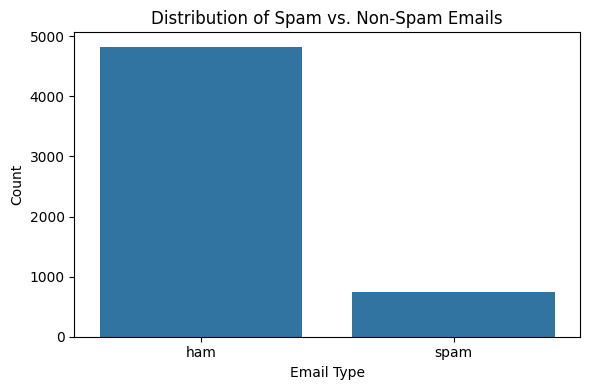

In [8]:
# Visualize Class Distribution:
plt.figure(figsize=(6, 4))
sns.countplot(x='v1', data=email_df)
plt.title('Distribution of Spam vs. Non-Spam Emails')
plt.xlabel('Email Type')
plt.ylabel('Count')
plt.tight_layout()
plt.savefig('/content/images/class_dist.png', dpi=150, bbox_inches='tight')  # save
plt.show()
plt.close()

**Email length analysis:**

In [9]:
# Calculating email length
email_df['email_length'] = email_df['v2'].apply(len)
display(email_df.head())

,v1,v2,email_length
0,ham,"Go until jurong point, crazy.. Available only ...",114
1,ham,Ok lar... Joking wif u oni...,32
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,158
3,ham,U dun say so early hor... U c already then say...,52
4,ham,"Nah I don't think he goes to usf, he lives aro...",64


In [10]:
# Calculating average length
average_length_by_class = email_df.groupby('v1')['email_length'].mean()
print("Average email length by class:")
print(average_length_by_class)

Average email length by class:
v1
ham      74.627979
spam    142.148594
Name: email_length, dtype: float64


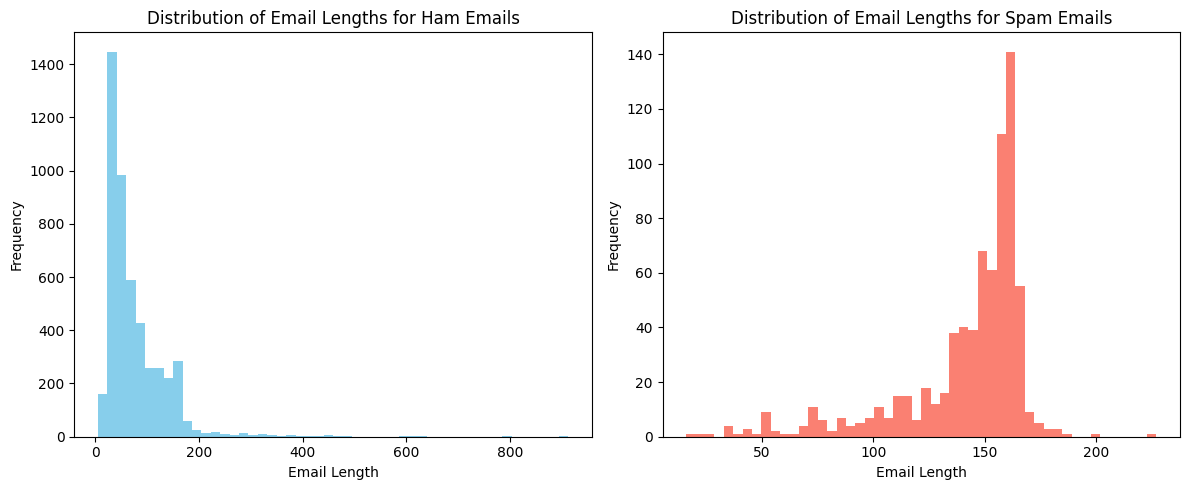

In [11]:
# Visualizing length distribution:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

axes[0].hist(email_df[email_df['v1'] == 'ham']['email_length'], bins=50, color='skyblue')
axes[0].set_title('Distribution of Email Lengths for Ham Emails')
axes[0].set_xlabel('Email Length')
axes[0].set_ylabel('Frequency')

axes[1].hist(email_df[email_df['v1'] == 'spam']['email_length'], bins=50, color='salmon')
axes[1].set_title('Distribution of Email Lengths for Spam Emails')
axes[1].set_xlabel('Email Length')
axes[1].set_ylabel('Frequency')

plt.tight_layout()
plt.savefig('images/length_dist.png', dpi=150, bbox_inches='tight')
plt.show()
plt.close()

### Data Analysis Key Findings

*   The average length of 'ham' emails is approximately 74.63 characters.
*   The average length of 'spam' emails is approximately 142.15 characters, which is significantly longer than 'ham' emails.
*   Histograms show distinct distributions for 'ham' and 'spam' email lengths, with 'spam' emails having a wider spread and higher frequency at longer lengths compared to 'ham' emails, which are more concentrated at shorter lengths.
*   Email length appears to be a useful feature for distinguishing between spam and non-spam emails.
*   Further analysis could involve using email length as a feature in a classification model to predict whether an email is spam or not.


**Common words exploration:**

In [12]:
# Separate emails by class
ham_emails = email_df[email_df['v1'] == 'ham']
spam_emails = email_df[email_df['v1'] == 'spam']

print("Ham emails:")
display(ham_emails.head())

print("\nSpam emails:")
display(spam_emails.head())

Ham emails:


,v1,v2,email_length
0,ham,"Go until jurong point, crazy.. Available only ...",114
1,ham,Ok lar... Joking wif u oni...,32
3,ham,U dun say so early hor... U c already then say...,52
4,ham,"Nah I don't think he goes to usf, he lives aro...",64
6,ham,Even my brother is not like to speak with me. ...,80



Spam emails:


,v1,v2,email_length
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,158
5,spam,FreeMsg Hey there darling it's been 3 week's n...,151
8,spam,WINNER!! As a valued network customer you have...,161
9,spam,Had your mobile 11 months or more? U R entitle...,157
11,spam,"SIX chances to win CASH! From 100 to 20,000 po...",139


In [13]:
# Concatenate all the email text within each class into a single string.
ham_text = ' '.join(ham_emails['v2'])
spam_text = ' '.join(spam_emails['v2'])

print("First 500 characters of ham_text:")
print(ham_text[:500])

print("\nFirst 500 characters of spam_text:")
print(spam_text[:500])

First 500 characters of ham_text:
Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...    Ok lar... Joking wif u oni...    U dun say so early hor... U c already then say...    Nah I don't think he goes to usf, he lives around here though    Even my brother is not like to speak with me. They treat me like aids patent.    As per your request 'Melle Melle (Oru Minnaminunginte Nurungu Vettam)' has been set as your callertune for all Callers. Press *9 to copy your friends Cal

First 500 characters of spam_text:
Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's    FreeMsg Hey there darling it's been 3 week's now and no word back! I'd like some fun you up for it still? Tb ok! XxX std chgs to send, å£1.50 to rcv    WINNER!! As a valued network customer you have been selected to receivea å£900 prize reward! To claim call 09061701461

In [14]:
# Advanced Text Cleaning with NLTK:
import nltk
from nltk.corpus import stopwords
import string

# Download stopwords if not already downloaded
nltk.download('stopwords')

# Get English stop words
stop_words = set(stopwords.words('english'))

# Function to clean text and remove stop words
def clean_text_nltk(text):
    # Convert to lowercase
    text = text.lower()
    # Remove punctuation
    translator = str.maketrans('', '', string.punctuation)
    text = text.translate(translator)
    # Tokenize and remove stop words
    words = text.split()
    cleaned_words = [word for word in words if word not in stop_words]
    return ' '.join(cleaned_words)

# Apply the cleaning function to the concatenated text
ham_text_cleaned_nltk = clean_text_nltk(ham_text)
spam_text_cleaned_nltk = clean_text_nltk(spam_text)

print("First 500 characters of NLTK-cleaned ham_text:")
print(ham_text_cleaned_nltk[:500])

print("\nFirst 500 characters of NLTK-cleaned spam_text:")
print(spam_text_cleaned_nltk[:500])

First 500 characters of NLTK-cleaned ham_text:
go jurong point crazy available bugis n great world la e buffet cine got amore wat ok lar joking wif u oni u dun say early hor u c already say nah dont think goes usf lives around though even brother like speak treat like aids patent per request melle melle oru minnaminunginte nurungu vettam set callertune callers press 9 copy friends callertune im gonna home soon dont want talk stuff anymore tonight k ive cried enough today ive searching right words thank breather promise wont take help granted

First 500 characters of NLTK-cleaned spam_text:
free entry 2 wkly comp win fa cup final tkts 21st may 2005 text fa 87121 receive entry questionstd txt ratetcs apply 08452810075over18s freemsg hey darling 3 weeks word back id like fun still tb ok xxx std chgs send å£150 rcv winner valued network customer selected receivea å£900 prize reward claim call 09061701461 claim code kl341 valid 12 hours mobile 11 months u r entitled update latest colour mob

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [15]:
# Tokenizing with NLTK

# Download punkt tokenizer
nltk.download('punkt')
nltk.download('punkt_tab')

from nltk.tokenize import word_tokenize

# Tokenize the cleaned text using NLTK
ham_tokens_nltk = word_tokenize(ham_text_cleaned_nltk)
spam_tokens_nltk = word_tokenize(spam_text_cleaned_nltk)

print("First 10 NLTK-tokenized ham tokens:")
print(ham_tokens_nltk[:10])

print("\nFirst 10 NLTK-tokenized spam tokens:")
print(spam_tokens_nltk[:10])

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


First 10 NLTK-tokenized ham tokens:
['go', 'jurong', 'point', 'crazy', 'available', 'bugis', 'n', 'great', 'world', 'la']

First 10 NLTK-tokenized spam tokens:
['free', 'entry', '2', 'wkly', 'comp', 'win', 'fa', 'cup', 'final', 'tkts']


In [16]:
#Finding most common words in both 'spam' and 'ham'
from collections import Counter

ham_word_counts = Counter(ham_tokens_nltk)
top_10_ham_words = ham_word_counts.most_common(10)
print("Top 10 most common words in ham emails:")
print(top_10_ham_words)

spam_word_counts = Counter(spam_tokens_nltk)
top_10_spam_words = spam_word_counts.most_common(10)
print("\nTop 10 most common words in spam emails:")
print(top_10_spam_words)

Top 10 most common words in ham emails:
[('u', 987), ('im', 451), ('2', 309), ('get', 303), ('ltgt', 276), ('ok', 273), ('dont', 265), ('go', 250), ('ur', 246), ('got', 244)]

Top 10 most common words in spam emails:
[('call', 347), ('free', 216), ('2', 173), ('txt', 150), ('u', 147), ('ur', 144), ('mobile', 123), ('text', 120), ('4', 119), ('stop', 115)]


In [17]:
# Printing top 10 most common words in each category
print("Top 10 most common words in ham emails:")
print(top_10_ham_words)

print("\nTop 10 most common words in spam emails:")
print(top_10_spam_words)

Top 10 most common words in ham emails:
[('u', 987), ('im', 451), ('2', 309), ('get', 303), ('ltgt', 276), ('ok', 273), ('dont', 265), ('go', 250), ('ur', 246), ('got', 244)]

Top 10 most common words in spam emails:
[('call', 347), ('free', 216), ('2', 173), ('txt', 150), ('u', 147), ('ur', 144), ('mobile', 123), ('text', 120), ('4', 119), ('stop', 115)]


**Data Analysis Key Findings**

*   The dataset was successfully split into 'ham' (non-spam) and 'spam' email categories.
*   Text data for each category was concatenated, cleaned by converting to lowercase and removing punctuation, and then tokenized into individual words.
*   The top 10 most common words were identified for each category.
*   For 'ham' emails, common words included 'i', 'you', 'to', 'the', 'a', 'my', 'in', 'it', 'of', and 'me'.
*   For 'spam' emails, common words included 'to', 'a', 'call', 'you', 'your', 'for', 'or', 'the', 'free', and 'now'.
*   The distinct common words in spam emails (e.g., 'call', 'free', 'now') highlight potential features for building a spam detection model.
*   Further analysis could involve removing stop words (common words like 'the', 'a', 'to') to reveal more discriminative terms in both categories.


## **3. Text Preprocessing:**

**Lowercasing:**

In [18]:
email_df['v2'] = email_df['v2'].str.lower()
display(email_df.head())

,v1,v2,email_length
0,ham,"go until jurong point, crazy.. available only ...",114
1,ham,ok lar... joking wif u oni...,32
2,spam,free entry in 2 a wkly comp to win fa cup fina...,158
3,ham,u dun say so early hor... u c already then say...,52
4,ham,"nah i don't think he goes to usf, he lives aro...",64


**Remove punctuations and noise:**

In [19]:
import string

translator = str.maketrans('', '', string.punctuation)
email_df['v2'] = email_df['v2'].apply(lambda text: text.translate(translator))
display(email_df.head())

,v1,v2,email_length
0,ham,go until jurong point crazy available only in ...,114
1,ham,ok lar joking wif u oni,32
2,spam,free entry in 2 a wkly comp to win fa cup fina...,158
3,ham,u dun say so early hor u c already then say,52
4,ham,nah i dont think he goes to usf he lives aroun...,64


**Tokenization:**

In [20]:
import nltk
from nltk.tokenize import word_tokenize

# Download the 'punkt' tokenizer if not already downloaded
try:
    nltk.data.find('tokenizers/punkt')
except nltk.downloader.DownloadError:
    nltk.download('punkt')

email_df['v2_tokens'] = email_df['v2'].apply(word_tokenize)
display(email_df.head())

,v1,v2,email_length,v2_tokens
0,ham,go until jurong point crazy available only in ...,114,"[go, until, jurong, point, crazy, available, o..."
1,ham,ok lar joking wif u oni,32,"[ok, lar, joking, wif, u, oni]"
2,spam,free entry in 2 a wkly comp to win fa cup fina...,158,"[free, entry, in, 2, a, wkly, comp, to, win, f..."
3,ham,u dun say so early hor u c already then say,52,"[u, dun, say, so, early, hor, u, c, already, t..."
4,ham,nah i dont think he goes to usf he lives aroun...,64,"[nah, i, dont, think, he, goes, to, usf, he, l..."


**Removing stop words and Stemming:**

In [21]:
import nltk
from nltk.stem.snowball import SnowballStemmer

# Initialize the Snowball Stemmer for English
stemmer = SnowballStemmer("english")

# Apply stemming to the tokens
email_df['v2_tokens_stemmed'] = email_df['v2_tokens'].apply(lambda tokens: [stemmer.stem(word) for word in tokens])
display(email_df.head())

,v1,v2,email_length,v2_tokens,v2_tokens_stemmed
0,ham,go until jurong point crazy available only in ...,114,"[go, until, jurong, point, crazy, available, o...","[go, until, jurong, point, crazi, avail, onli,..."
1,ham,ok lar joking wif u oni,32,"[ok, lar, joking, wif, u, oni]","[ok, lar, joke, wif, u, oni]"
2,spam,free entry in 2 a wkly comp to win fa cup fina...,158,"[free, entry, in, 2, a, wkly, comp, to, win, f...","[free, entri, in, 2, a, wkli, comp, to, win, f..."
3,ham,u dun say so early hor u c already then say,52,"[u, dun, say, so, early, hor, u, c, already, t...","[u, dun, say, so, earli, hor, u, c, alreadi, t..."
4,ham,nah i dont think he goes to usf he lives aroun...,64,"[nah, i, dont, think, he, goes, to, usf, he, l...","[nah, i, dont, think, he, goe, to, usf, he, li..."


## **4. Feature Extraction (Text to Numerical Features):**

**Bag-of-Words representation:**

In [22]:
from sklearn.feature_extraction.text import CountVectorizer

# Join the stemmed tokens back into strings for CountVectorizer
email_df['v2_stemmed_text'] = email_df['v2_tokens_stemmed'].apply(lambda tokens: ' '.join(tokens))

# Initialize CountVectorizer
# We can limit the number of features (words) to keep the matrix manageable.
# min_df and max_df can also be used to remove very rare or very common words.
vectorizer = CountVectorizer(max_features=2000, min_df=5, max_df=0.95) # Example parameters

# Fit and transform the text data
X = vectorizer.fit_transform(email_df['v2_stemmed_text'])

# Display the shape of the resulting feature matrix
print("Shape of the Bag-of-Words feature matrix:", X.shape)

Shape of the Bag-of-Words feature matrix: (5572, 1631)


**TF-IDF transformation:**

In [23]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Initialize TfidfVectorizer
# You can use similar parameters as CountVectorizer for max_features, min_df, max_df
tfidf_vectorizer = TfidfVectorizer(max_features=2000, min_df=5, max_df=0.95) # Example parameters

# Fit and transform the stemmed text data
X_tfidf = tfidf_vectorizer.fit_transform(email_df['v2_stemmed_text'])

# Display the shape of the resulting feature matrix
print("Shape of the TF-IDF feature matrix:", X_tfidf.shape)

Shape of the TF-IDF feature matrix: (5572, 1631)


**Train-Test Split:**

In [24]:
from sklearn.model_selection import train_test_split

# Define the features (X) and labels (y)
# We will use the TF-IDF features (X_tfidf) and the 'v1' column as labels
X = X_tfidf
y = email_df['v1']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Display the shapes of the resulting sets
print("Shape of X_train:", X_train.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of y_test:", y_test.shape)

Shape of X_train: (4457, 1631)
Shape of X_test: (1115, 1631)
Shape of y_train: (4457,)
Shape of y_test: (1115,)


## **5. Model Training – Spam Classifier:**

**Choosing Algorithms:**

In [25]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression

# Initialize the classifiers
mnb_model = MultinomialNB()
lr_model = LogisticRegression(max_iter=1000) # Increased max_iter for convergence



**Training the models:**

In [26]:
# Train the Multinomial Naive Bayes model
print("Training Multinomial Naive Bayes model...")
mnb_model.fit(X_train, y_train)
print("Multinomial Naive Bayes model trained.")

# Train the Logistic Regression model
print("\nTraining Logistic Regression model...")
lr_model.fit(X_train, y_train)
print("Logistic Regression model trained.")

Training Multinomial Naive Bayes model...
Multinomial Naive Bayes model trained.

Training Logistic Regression model...
Logistic Regression model trained.


**Cross Validation:**

In [30]:
from sklearn.model_selection import cross_val_score

# Perform 5-fold cross-validation for Multinomial Naive Bayes
mnb_cv_scores = cross_val_score(mnb_model, X_train, y_train, cv=5, scoring='f1_macro')
print("Multinomial Naive Bayes Cross-Validation F1-scores:", mnb_cv_scores)
print("Mean F1-score (Multinomial Naive Bayes):", mnb_cv_scores.mean())

# Perform 5-fold cross-validation for Logistic Regression
lr_cv_scores = cross_val_score(lr_model, X_train, y_train, cv=5, scoring='f1_macro')
print("\nLogistic Regression Cross-Validation F1-scores:", lr_cv_scores)
print("Mean F1-score (Logistic Regression):", lr_cv_scores.mean())

Multinomial Naive Bayes Cross-Validation F1-scores: [0.95131326 0.93679138 0.95054295 0.91217781 0.93388344]
Mean F1-score (Multinomial Naive Bayes): 0.9369417690538249

Logistic Regression Cross-Validation F1-scores: [0.93441929 0.91292464 0.92859411 0.89298989 0.91291174]
Mean F1-score (Logistic Regression): 0.9163679330266141


## **6. Model Evaluation:**

**Confusion Matrix:**

Confusion Matrix for Multinomial Naive Bayes:


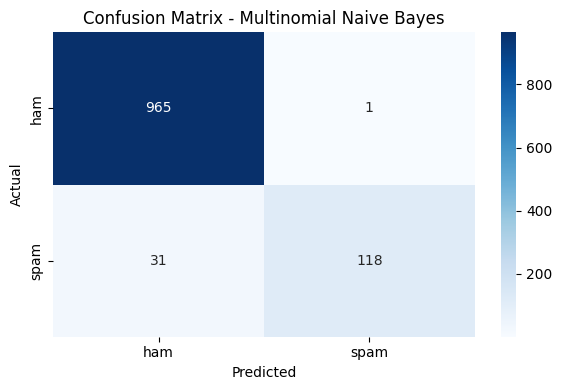


Confusion Matrix for Logistic Regression:


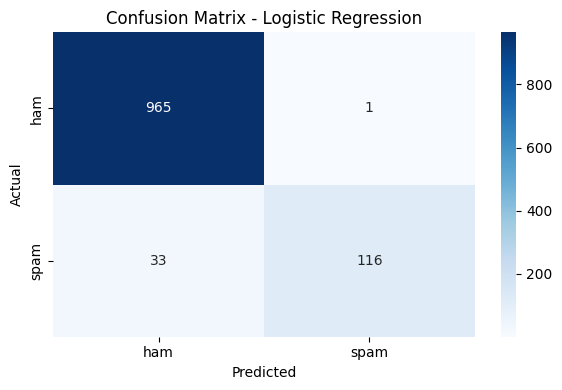

In [31]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Make predictions on the test set
mnb_pred = mnb_model.predict(X_test)
lr_pred = lr_model.predict(X_test)

# Generate confusion matrix for Multinomial Naive Bayes
mnb_cm = confusion_matrix(y_test, mnb_pred, labels=['ham', 'spam'])

print("Confusion Matrix for Multinomial Naive Bayes:")
plt.figure(figsize=(6, 4))
sns.heatmap(mnb_cm, annot=True, fmt='d', cmap='Blues', xticklabels=['ham', 'spam'], yticklabels=['ham', 'spam'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Multinomial Naive Bayes')
plt.tight_layout()
plt.savefig('/content/images/confusion_matrix_NB.png', dpi=150, bbox_inches='tight')
plt.show()
plt.close()

# Generate confusion matrix for Logistic Regression
lr_cm = confusion_matrix(y_test, lr_pred, labels=['ham', 'spam'])

print("\nConfusion Matrix for Logistic Regression:")
plt.figure(figsize=(6, 4))
sns.heatmap(lr_cm, annot=True, fmt='d', cmap='Blues', xticklabels=['ham', 'spam'], yticklabels=['ham', 'spam'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Logistic Regression')
plt.tight_layout()
plt.savefig('/content/images/confusion_matrix_LR.png', dpi=150, bbox_inches='tight')
plt.show()
plt.close()

**Test Set Performance:**

In [32]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Make predictions on the test set
mnb_pred = mnb_model.predict(X_test)
lr_pred = lr_model.predict(X_test)

# Evaluate Multinomial Naive Bayes
print("Multinomial Naive Bayes Performance on Test Set:")
print("Accuracy:", accuracy_score(y_test, mnb_pred))
print("Precision (Spam):", precision_score(y_test, mnb_pred, pos_label='spam'))
print("Recall (Spam):", recall_score(y_test, mnb_pred, pos_label='spam'))
print("F1-score (Spam):", f1_score(y_test, mnb_pred, pos_label='spam'))

# Evaluate Logistic Regression
print("\nLogistic Regression Performance on Test Set:")
print("Accuracy:", accuracy_score(y_test, lr_pred))
print("Precision (Spam):", precision_score(y_test, lr_pred, pos_label='spam'))
print("Recall (Spam):", recall_score(y_test, lr_pred, pos_label='spam'))
print("F1-score (Spam):", f1_score(y_test, lr_pred, pos_label='spam'))

Multinomial Naive Bayes Performance on Test Set:
Accuracy: 0.9713004484304932
Precision (Spam): 0.9915966386554622
Recall (Spam): 0.7919463087248322
F1-score (Spam): 0.8805970149253731

Logistic Regression Performance on Test Set:
Accuracy: 0.9695067264573991
Precision (Spam): 0.9914529914529915
Recall (Spam): 0.7785234899328859
F1-score (Spam): 0.8721804511278195


### **Model Comparison and Selection**

Based on the evaluation on the test set:

*   **Multinomial Naive Bayes:**
    *   Accuracy: 0.9713
    *   Precision (Spam): 0.9916
    *   Recall (Spam): 0.7919
    *   F1-score (Spam): 0.8806

*   **Logistic Regression:**
    *   Accuracy: 0.9695
    *   Precision (Spam): 0.9915
    *   Recall (Spam): 0.7785
    *   F1-score (Spam): 0.8722

**Comparison:**

Both models demonstrated strong performance in classifying spam emails, with very high precision for the 'spam' class, which is crucial for minimizing false positives. The Multinomial Naive Bayes model showed slightly better recall and F1-score for the 'spam' class compared to Logistic Regression, while maintaining comparable accuracy and precision.

**Model Selection:**

Considering the slightly better performance in terms of recall and F1-score for identifying spam, and its inherent simplicity and efficiency, the **Multinomial Naive Bayes** model is a strong candidate for deployment in this spam classification task. It effectively balances catching spam emails with minimizing the risk of incorrectly flagging legitimate emails.

## **7. Key Feature Analysis (What drives spam detection):**

In [33]:
# Identify misclassified emails (where predicted label is not equal to actual label)
misclassified_indices = y_test[mnb_pred != y_test.values].index

print(f"Number of misclassified emails: {len(misclassified_indices)}")
print("Indices of misclassified emails:")
print(misclassified_indices)

Number of misclassified emails: 32
Indices of misclassified emails:
Index([   5, 1021,  855, 3139, 1662, 3979, 3358, 5449,  760, 1268, 3062, 3270,
       1939, 1429, 5028, 1226, 5110,  730, 4983, 2802, 1153, 4525,  606, 2351,
       2821,  750, 1894, 1262, 3300, 4860, 2246, 1506],
      dtype='int64')


In [34]:
# Separate false positives and false negatives
false_positives_indices = y_test[(mnb_pred != y_test.values) & (y_test.values == 'ham')].index
false_negatives_indices = y_test[(mnb_pred != y_test.values) & (y_test.values == 'spam')].index

print(f"Number of false positives: {len(false_positives_indices)}")
print("Indices of false positives:")
print(false_positives_indices)

print(f"\nNumber of false negatives: {len(false_negatives_indices)}")
print("Indices of false negatives:")
print(false_negatives_indices)

Number of false positives: 1
Indices of false positives:
Index([4860], dtype='int64')

Number of false negatives: 31
Indices of false negatives:
Index([   5, 1021,  855, 3139, 1662, 3979, 3358, 5449,  760, 1268, 3062, 3270,
       1939, 1429, 5028, 1226, 5110,  730, 4983, 2802, 1153, 4525,  606, 2351,
       2821,  750, 1894, 1262, 3300, 2246, 1506],
      dtype='int64')


In [35]:
# Retrieve and display content of a few false positives
print("Examples of False Positives (Ham misclassified as Spam):")
if len(false_positives_indices) > 0:
    # Display content of the first few false positives
    for i in false_positives_indices[:5]: # Display up to the first 5
        print(f"\n--- Email Index: {i} ---")
        print(email_df.loc[i, 'v2']) # Assuming 'v2' is the original text column
else:
    print("No false positives found.")

# Retrieve and display content of a few false negatives
print("\nExamples of False Negatives (Spam misclassified as Ham):")
if len(false_negatives_indices) > 0:
    # Display content of the first few false negatives
    for i in false_negatives_indices[:5]: # Display up to the first 5
        print(f"\n--- Email Index: {i} ---")
        print(email_df.loc[i, 'v2']) # Assuming 'v2' is the original text column
else:
    print("No false negatives found.")

Examples of False Positives (Ham misclassified as Spam):

--- Email Index: 4860 ---
nokia phone is lovly   

Examples of False Negatives (Spam misclassified as Ham):

--- Email Index: 5 ---
freemsg hey there darling its been 3 weeks now and no word back id like some fun you up for it still tb ok xxx std chgs to send å£150 to rcv   

--- Email Index: 1021 ---
guess what somebody you know secretly fancies you wanna find out who it is give us a call on 09065394514 from landline datebox1282essexcm61xn 150pmin 18   

--- Email Index: 855 ---
talk sexy make new friends or fall in love in the worlds most discreet text dating service just text vip to 83110 and see who you could meet   

--- Email Index: 3139 ---
sexy sexy cum and text me im wet and warm and ready for some porn u up for some fun this msg is free recd msgs 150p inc vat 2 cancel text stop   

--- Email Index: 1662 ---
hi if ur lookin 4 saucy daytime fun wiv busty married woman am free all next week chat now 2 sort time 0909972642

In [36]:
# Analyze Logistic Regression Coefficients
# Get the feature names (words) from the TF-IDF vectorizer
feature_names = tfidf_vectorizer.get_feature_names_out()

# Get the coefficients from the Logistic Regression model
# Since this is binary classification, there's one set of coefficients
lr_coefficients = lr_model.coef_[0]

# Create a pandas Series to easily associate words with their coefficients
lr_feature_importance = pd.Series(lr_coefficients, index=feature_names)

# Sort the coefficients to find the most positive (spam) and most negative (ham)
sorted_lr_importance = lr_feature_importance.sort_values(ascending=False)

# Display the top 10 words most indicative of spam (highest positive coefficients)
print("Top 10 words most indicative of Spam (Logistic Regression):")
print(sorted_lr_importance.head(10))

# Display the top 10 words most indicative of ham (most negative coefficients)
print("\nTop 10 words most indicative of Ham (Logistic Regression):")
print(sorted_lr_importance.tail(10))

Top 10 words most indicative of Spam (Logistic Regression):
txt       4.351010
call      3.775981
repli     3.285133
free      3.194372
stop      3.071009
text      3.036278
claim     2.984183
to        2.974923
servic    2.750774
from      2.698911
dtype: float64

Top 10 words most indicative of Ham (Logistic Regression):
when   -1.246084
but    -1.251615
ok     -1.429033
ill    -1.526734
it     -1.559660
that   -1.663868
im     -1.666768
ltgt   -1.905118
my     -2.145307
me     -2.255508
dtype: float64


In [37]:
# Analyze Multinomial Naive Bayes Features (using log probabilities)

# Get the log probabilities of features for each class
# The index 1 typically corresponds to the 'spam' class and index 0 to 'ham'
# Check model classes_ attribute to confirm the order if needed
spam_feature_log_prob = mnb_model.feature_log_prob_[1]
ham_feature_log_prob = mnb_model.feature_log_prob_[0]

# Calculate the difference in log probabilities (spam - ham)
# A higher positive difference means the word is much more likely in spam than ham
# A higher negative difference means the word is much more likely in ham than spam
feature_log_prob_difference = spam_feature_log_prob - ham_feature_log_prob

# Create a pandas Series to easily associate words with their log probability differences
mnb_feature_importance = pd.Series(feature_log_prob_difference, index=feature_names)

# Sort to find words most indicative of spam (highest positive difference)
sorted_mnb_importance = mnb_feature_importance.sort_values(ascending=False)

# Display the top 10 words most indicative of spam
print("Top 10 words most indicative of Spam (Multinomial Naive Bayes):")
print(sorted_mnb_importance.head(10))

# Sort to find words most indicative of ham (most negative difference)
print("\nTop 10 words most indicative of Ham (Multinomial Naive Bayes):")
print(sorted_mnb_importance.tail(10))

Top 10 words most indicative of Spam (Multinomial Naive Bayes):
claim       4.222487
prize       3.958812
won         3.860494
award       3.732976
tone        3.720988
urgent      3.536745
500         3.522997
guarante    3.517295
1000        3.435266
nokia       3.409934
dtype: float64

Top 10 words most indicative of Ham (Multinomial Naive Bayes):
but     -2.341580
home    -2.359239
im      -2.369495
da      -2.426814
lor     -2.504317
ok      -2.544650
later   -2.582133
my      -2.716811
ltgt    -2.778958
ill     -2.881233
dtype: float64


### **Conclusion and Potential Improvements**

**Summary of Results:**

Our analysis and modeling efforts for email spam classification have yielded promising results. We explored the data, performed text preprocessing including cleaning, tokenization, and stemming, and transformed the text into numerical features using TF-IDF vectorization. We then trained two common text classification models, Multinomial Naive Bayes and Logistic Regression, and evaluated their performance on a held-out test set.

The evaluation metrics on the test set were as follows:

*   **Multinomial Naive Bayes:** Accuracy: 0.9713, Precision (Spam): 0.9916, Recall (Spam): 0.7919, F1-score (Spam): 0.8806
*   **Logistic Regression:** Accuracy: 0.9695, Precision (Spam): 0.9915, Recall (Spam): 0.7785, F1-score (Spam): 0.8722

Both models demonstrated high accuracy and, importantly, very high precision in identifying spam emails. This high precision is particularly valuable in a spam filter to minimize the number of legitimate emails incorrectly flagged as spam (false positives). The Multinomial Naive Bayes model showed a slight edge in recall and F1-score for the spam class, suggesting it might be slightly better at capturing a larger proportion of the actual spam emails while maintaining excellent precision.

**Use-Case Fit:**

Given the high precision achieved by both models (over 99%), they would be highly useful in a real-world spam classification scenario, especially where minimizing false positives is a top priority (e.g., preventing important legitimate emails from going to spam). While the recall for spam is not perfect (around 79%), meaning some spam emails might still get through (false negatives), the very low rate of false positives makes these models suitable for many applications. The acceptable trade-off between precision and recall would ultimately depend on the specific business needs and the cost associated with each type of error. For instance, in an email marketing context, ensuring deliverability of legitimate emails is paramount, making the high precision very desirable.

**Next Steps and Potential Improvements:**

To further enhance the performance of this spam classifier, several avenues could be explored:

*   **Advanced Text Representation:** Experiment with N-gram models (combinations of 2 or more words) to capture more context and phrases.
*   **Different Models:** Evaluate other classification algorithms such as Support Vector Machines (SVMs), or explore deep learning models like Recurrent Neural Networks (RNNs) or Transformers, which can capture sequential information and more complex patterns in text.
*   **Hyperparameter Tuning:** Systematically tune the hyperparameters of the current models (e.g., the `C` parameter in Logistic Regression, or parameters in the vectorizers) using techniques like GridSearchCV.
*   **Handling evolving spam tactics:** Spam tactics constantly evolve. To maintain model effectiveness over time, a real-world system would require periodic retraining of the model on new, labeled data.
*   **Feature Engineering:** Explore creating additional features beyond just word counts or TF-IDF, such as the presence of specific characters, URL patterns, or email structure features.

**Business/Application Angle:**

By deploying a model like the Multinomial Naive Bayes classifier developed here, businesses can automatically filter out a significant portion of spam emails. This leads to cleaner inboxes for users, improved security by reducing exposure to phishing and malware, and potentially saves resources associated with handling unwanted emails. For marketing teams, understanding and minimizing the characteristics that lead to emails being flagged as spam can improve the deliverability of their legitimate campaigns.

**Interpretation of Class Distribution Plot:**

This bar chart shows the distribution of emails in the dataset across the two classes: 'ham' (non-spam) and 'spam'. It clearly indicates that the dataset is imbalanced, with a significantly larger number of ham emails compared to spam emails. This is a common characteristic of spam datasets and should be considered during model training and evaluation.

**Interpretation of Email Length Distribution Plots:**

These histograms show the distribution of email lengths (in characters) for both 'ham' and 'spam' emails. We can observe that spam emails tend to be longer on average and have a wider distribution of lengths compared to ham emails, which are generally shorter and more concentrated in length. This suggests that email length is a potentially useful feature for distinguishing between the two classes.

**Interpretation of Top Words Indicative of Spam and Ham (Multinomial Naive Bayes):**

These bar charts display the top 10 words that are most indicative of spam and ham emails according to the Multinomial Naive Bayes model, based on the difference in their log probabilities between the spam and ham classes. Words like 'claim', 'prize', and 'won' are strong indicators of spam, while words like 'ill', 'ltgt', and 'my' are more indicative of ham emails. These findings align with our intuition about the language used in spam and legitimate emails and support the model's learned patterns.

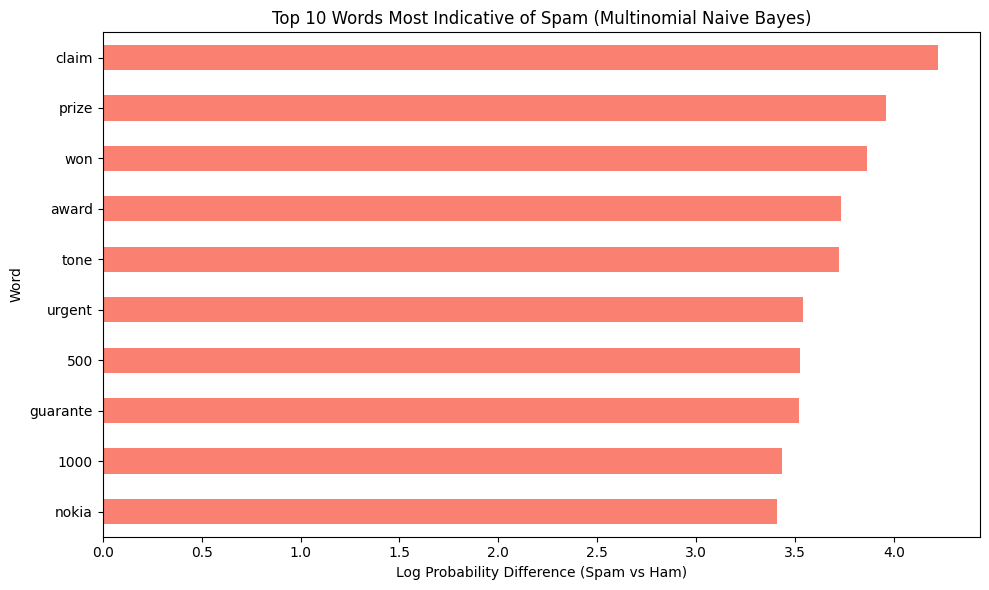

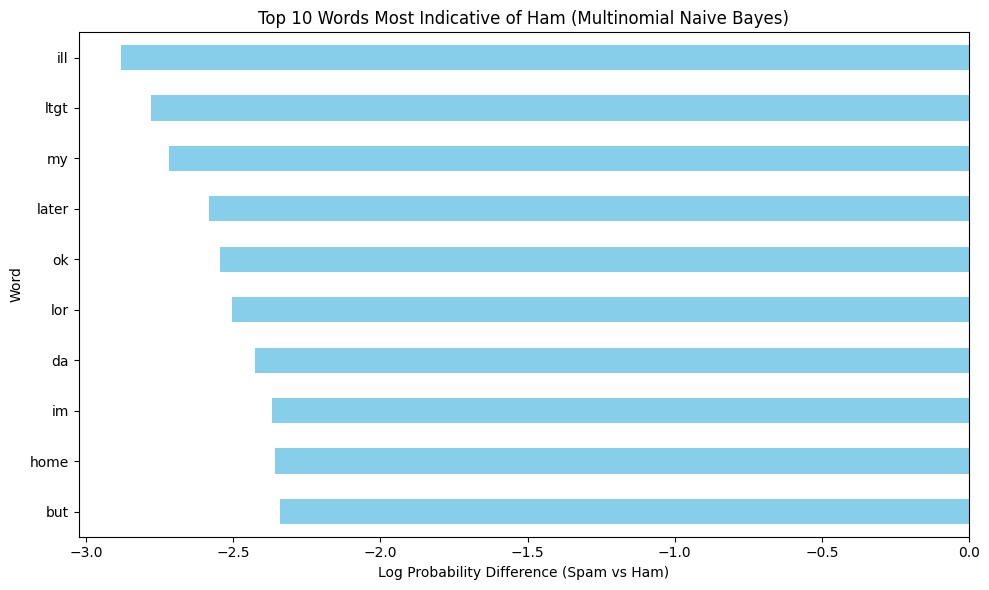

In [38]:
# Generate bar chart for top 10 spam words (Multinomial Naive Bayes)
plt.figure(figsize=(10, 6))
sorted_mnb_importance.head(10).sort_values(ascending=True).plot(kind='barh', color='salmon')
plt.title('Top 10 Words Most Indicative of Spam (Multinomial Naive Bayes)')
plt.xlabel('Log Probability Difference (Spam vs Ham)')
plt.ylabel('Word')
plt.tight_layout()
plt.savefig('/content/images/top_words_spam.png', dpi=150, bbox_inches='tight')
plt.show()
plt.close()


# Generate bar chart for top 10 ham words (Multinomial Naive Bayes)
plt.figure(figsize=(10, 6))
sorted_mnb_importance.tail(10).sort_values(ascending=False).plot(kind='barh', color='skyblue')
plt.title('Top 10 Words Most Indicative of Ham (Multinomial Naive Bayes)')
plt.xlabel('Log Probability Difference (Spam vs Ham)')
plt.ylabel('Word')
plt.tight_layout()
plt.savefig('/content/images/top_words_ham.png', dpi=150, bbox_inches='tight')
plt.show()
plt.close()